### Imports

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# os.environ["TRANSFORMERS_CACHE"] = ""
# os.environ["HF_DATASETS_CACHE"] = ""

In [1]:
!git clone https://github.com/jannik-brinkmann/vision-transformerlens.git

Cloning into 'vision-transformerlens'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 62 (delta 29), reused 40 (delta 14), pack-reused 0
Unpacking objects: 100% (62/62), 5.57 MiB | 4.27 MiB/s, done.


In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch
from datasets import load_dataset

from lens import HookedHFTransformer

### Load Mistral 7B

In [4]:
from transformers import AutoModelForCausalLM, AutoTokenizer


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load a model (e.g. Mistral 7B). 
model_name_or_path = "mistralai/Mistral-7B-v0.1"
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.1", device_map={"": 0}, torch_dtype="auto")
model = AutoModelForCausalLM.from_pretrained(model_name_or_path, device_map={"": 0}, torch_dtype="auto")
model = HookedHFTransformer(model, device)

# preprocess some prompt and cache the activations
prompt = "When Mary and John went to the store, John gave a drink to"
tokens = tokenizer([prompt], return_tensors="pt").to(device)
outputs, activations = model.run_with_cache(**tokens)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

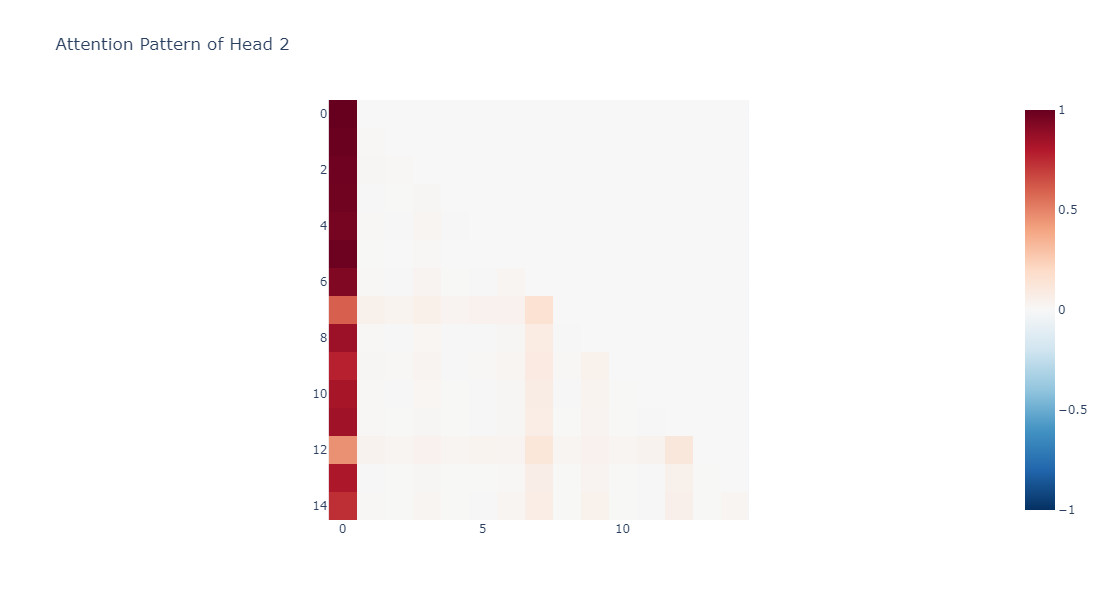

In [58]:
import math
import plotly.express as px
import torch.nn as nn


def transpose_k_for_scores(x: torch.Tensor) -> torch.Tensor:
    attention_head_size = int(model.config.hidden_size / model.config.num_attention_heads)
    new_x_shape = x.size()[:-1] + (model.config.num_key_value_heads, attention_head_size)
    x = x.view(new_x_shape)
    return x.permute(0, 2, 1, 3)

def transpose_q_for_scores(x: torch.Tensor) -> torch.Tensor:
    attention_head_size = int(model.config.hidden_size / model.config.num_attention_heads)
    new_x_shape = x.size()[:-1] + (model.config.num_attention_heads, attention_head_size)
    x = x.view(new_x_shape)
    return x.permute(0, 2, 1, 3)

def repeat_kv(hidden_states: torch.Tensor, n_rep: int) -> torch.Tensor:
    """
    This is the equivalent of torch.repeat_interleave(x, dim=1, repeats=n_rep). The hidden states go from (batch,
    num_key_value_heads, seqlen, head_dim) to (batch, num_attention_heads, seqlen, head_dim)
    """
    batch, num_key_value_heads, slen, head_dim = hidden_states.shape
    if n_rep == 1:
        return hidden_states
    hidden_states = hidden_states[:, :, None, :, :].expand(batch, num_key_value_heads, n_rep, slen, head_dim)
    return hidden_states.reshape(batch, num_key_value_heads * n_rep, slen, head_dim)

def make_sliding_window_causal_mask(
    input_ids_shape: torch.Size,
    dtype: torch.dtype,
    device: torch.device,
    past_key_values_length: int = 0,
    sliding_window: int = 4096,
):
    """
    Make causal mask used for sliding window attention
    """
    bsz, tgt_len = input_ids_shape

    tensor = torch.full(
        (tgt_len, tgt_len),
        fill_value=1,
        device=device,
    )
    mask = torch.tril(tensor, diagonal=0)
    # make the mask banded to account for sliding window
    mask = torch.triu(mask, diagonal=-sliding_window)
    mask = torch.log(mask).to(dtype)

    if past_key_values_length > 0:
        mask = torch.cat([torch.zeros(tgt_len, past_key_values_length, dtype=dtype, device=device), mask], dim=-1)
    return mask[None, None, :, :].expand(bsz, 1, tgt_len, tgt_len + past_key_values_length)


def compute_attention_patterns(activations: dict, layer: int):

    key_layer = transpose_k_for_scores(activations[f"model.layers.{layer}.self_attn.k_proj"])
    query_layer = transpose_q_for_scores(activations[f"model.layers.{layer}.self_attn.q_proj"])

    key_layer = repeat_kv(key_layer, model.config.num_attention_heads // model.config.num_key_value_heads)

    # take the dot product between "query" and "key" to get the raw attention scores
    attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
    attention_scores = attention_scores / math.sqrt(int(model.config.hidden_size / model.config.num_attention_heads))

    attention_mask = make_sliding_window_causal_mask(tokens["input_ids"].shape, tokens["input_ids"].dtype, "cuda")
    if attention_mask is not None:
        attention_scores = attention_scores + attention_mask

    # normalize the attention scores to probabilities
    attention_probs = nn.functional.softmax(attention_scores, dim=-1)
    #.to(dtype=torch.float16) needed for mistral loading in half precision
    return attention_probs.cpu().to(dtype=torch.float16)

def compute_all_attention_patterns(activations: dict):
    tensor_list = []
    for layer in range(model.config.num_hidden_layers):
        tensor_list.append(compute_attention_patterns(activations, layer))
    return torch.stack(tensor_list, dim=1) # shape: (batch_size, n_layers, n_heads, seq_len, seq_len)

def display_attention_head(layer:int, head: int):

    attention_patterns = compute_attention_patterns(activations, layer)  # shape: (batch_size, n_heads, seq_len, seq_len)

    attention_pattern = attention_patterns[0, head, :, :]
    fig = px.imshow(
        attention_pattern,
        title=f"Attention Pattern of Head {head}",
        color_continuous_scale='RdBu_r',
        zmin=-1, zmax=1,
        height=600, width=600
    )
    fig.show()


display_attention_head(0, 2)

In [55]:
attention_patterns_global = compute_all_attention_patterns(activations).numpy()
attention_patterns_global.shape

### Image (VisionTransformer)

In [7]:
from transformers import AutoImageProcessor, ViTForMaskedImageModeling


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load a model (e.g. ViT Base)
model_name_or_path = "google/vit-base-patch16-224"
model = ViTForMaskedImageModeling.from_pretrained(model_name_or_path)
model = HookedHFTransformer(model, device)
image_processor = AutoImageProcessor.from_pretrained(model_name_or_path)
dataset = load_dataset(
    "cifar10",
    cache_dir="./../cache",
    task="image-classification"
)

# setup boolean mask
num_patches = (model.config.image_size // model.config.patch_size) ** 2
bool_masked_pos = torch.randint(low=0, high=2, size=(1, num_patches)).bool().to(device)

# extract image features
features = image_processor(images=dataset['test']['image'][0], return_tensors="pt")
features.to(device)

# run the model and get outputs and activations
outputs, activations = model.run_with_cache(**features, bool_masked_pos=bool_masked_pos)

Some weights of ViTForMaskedImageModeling were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.embeddings.mask_token', 'decoder.0.weight', 'decoder.0.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
activations.keys()

dict_keys(['vit.embeddings.patch_embeddings.projection', 'vit.embeddings.patch_embeddings', 'vit.embeddings.dropout', 'vit.embeddings', 'vit.encoder.layer.0.layernorm_before', 'vit.encoder.layer.0.attention.attention.query', 'vit.encoder.layer.0.attention.attention.key', 'vit.encoder.layer.0.attention.attention.value', 'vit.encoder.layer.0.attention.attention.dropout', 'vit.encoder.layer.0.attention.output.dense', 'vit.encoder.layer.0.attention.output.dropout', 'vit.encoder.layer.0.attention.output', 'vit.encoder.layer.0.layernorm_after', 'vit.encoder.layer.0.intermediate.dense', 'vit.encoder.layer.0.intermediate.intermediate_act_fn', 'vit.encoder.layer.0.intermediate', 'vit.encoder.layer.0.output.dense', 'vit.encoder.layer.0.output.dropout', 'vit.encoder.layer.0.output', 'vit.encoder.layer.1.layernorm_before', 'vit.encoder.layer.1.attention.attention.query', 'vit.encoder.layer.1.attention.attention.key', 'vit.encoder.layer.1.attention.attention.value', 'vit.encoder.layer.1.attention.a

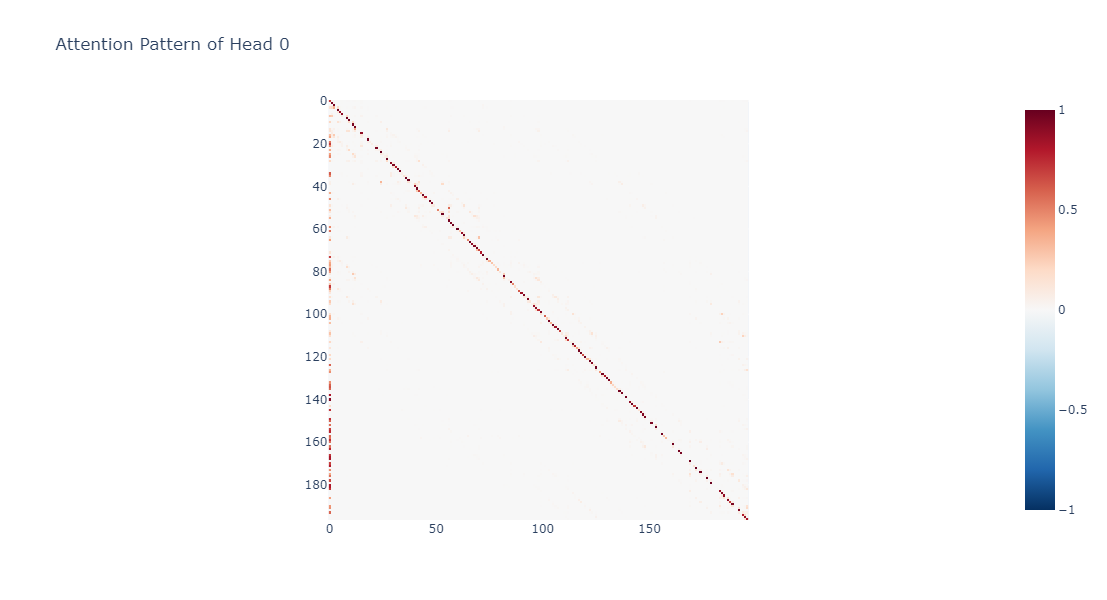

In [9]:
import math
import plotly.express as px
import torch.nn as nn

def transpose_for_scores(x: torch.Tensor) -> torch.Tensor:
    attention_head_size = int(model.config.hidden_size / model.config.num_attention_heads)
    new_x_shape = x.size()[:-1] + (model.config.num_attention_heads, attention_head_size)
    x = x.view(new_x_shape)
    return x.permute(0, 2, 1, 3)

def compute_attention_patterns(activations: dict, layer: int):

    key_layer = transpose_for_scores(activations[f"vit.encoder.layer.{layer}.attention.attention.key"])
    query_layer = transpose_for_scores(activations[f"vit.encoder.layer.{layer}.attention.attention.query"])

    # take the dot product between "query" and "key" to get the raw attention scores
    attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
    attention_scores = attention_scores / math.sqrt(int(model.config.hidden_size / model.config.num_attention_heads))

    # normalize the attention scores to probabilities
    attention_probs = nn.functional.softmax(attention_scores, dim=-1)
    return attention_probs.cpu()


def display_attention_head(layer:int, head: int):

    attention_patterns = compute_attention_patterns(activations, layer)  # shape: (batch_size, n_heads, seq_len, seq_len)

    attention_pattern = attention_patterns[0, head, :, :]
    fig = px.imshow(
        attention_pattern,
        title=f"Attention Pattern of Head {head}",
        color_continuous_scale='RdBu_r',
        zmin=-1, zmax=1,
        height=600, width=600
    )
    fig.show()


display_attention_head(0, 0)

In [10]:
layer_to_ablate = 0
head_index_to_ablate = 0
def head_ablation_hook(value, hook):
    
    # convert (batch_size, seq_len, d_model) to (batch_size, n_heads, seq_len, d_head)
    value = transpose_for_scores(value)

    # zero-ablate an attention head
    value[:, head_index_to_ablate, :, :] = 0.

    # convert (batch_size, n_heads, sew_len, d_head) to (batch_size, seq_len, d_model)
    value = value.permute(0, 2, 1, 3).flatten(2, 3)
    return value


original_loss = model(**features, bool_masked_pos=bool_masked_pos, return_dict=True)["loss"]
ablated_loss = model.run_with_hooks(
    **features,
    bool_masked_pos=bool_masked_pos,
    fwd_hooks=[(
        "vit.encoder.layer.0.attention.attention.value",
        head_ablation_hook
        )]
    )["loss"]
print(f"Original Loss: {original_loss}")
print(f"Ablated Loss: {ablated_loss}")

Original Loss: 0.49961572885513306
Ablated Loss: 0.49486494064331055


CLIP

In [11]:
from PIL import Image
import requests

from transformers import CLIPModel, CLIPProcessor


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load a model (e.g. ViT Base)
model_name_or_path = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name_or_path)
model = HookedHFTransformer(model, device)
processor = CLIPProcessor.from_pretrained(model_name_or_path)

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# extract image features
inputs = processor(text=["a photo of a cat", "a photo of a dog"], images=image, return_tensors="pt", padding=True)
inputs.to(device)

# run the model and get outputs and activations
outputs, activations = model.run_with_cache(**inputs)

In [12]:
activations.keys()

dict_keys(['vision_model.embeddings.patch_embedding', 'vision_model.embeddings.position_embedding', 'vision_model.embeddings', 'vision_model.pre_layrnorm', 'vision_model.encoder.layers.0.layer_norm1', 'vision_model.encoder.layers.0.self_attn.q_proj', 'vision_model.encoder.layers.0.self_attn.k_proj', 'vision_model.encoder.layers.0.self_attn.v_proj', 'vision_model.encoder.layers.0.self_attn.out_proj', 'vision_model.encoder.layers.0.layer_norm2', 'vision_model.encoder.layers.0.mlp.fc1', 'vision_model.encoder.layers.0.mlp.activation_fn', 'vision_model.encoder.layers.0.mlp.fc2', 'vision_model.encoder.layers.0.mlp', 'vision_model.encoder.layers.1.layer_norm1', 'vision_model.encoder.layers.1.self_attn.q_proj', 'vision_model.encoder.layers.1.self_attn.k_proj', 'vision_model.encoder.layers.1.self_attn.v_proj', 'vision_model.encoder.layers.1.self_attn.out_proj', 'vision_model.encoder.layers.1.layer_norm2', 'vision_model.encoder.layers.1.mlp.fc1', 'vision_model.encoder.layers.1.mlp.activation_fn'